# Sale Prediction

In [54]:
import pandas as pd
import numpy as np
from datetime import datetime, date

In [55]:
import seaborn as sns

In [58]:
# load data
categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("sales_train.csv")

In [59]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [60]:
i_train = train[['date_block_num', 'item_cnt_day']]
i_train = i_train.groupby(['date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})

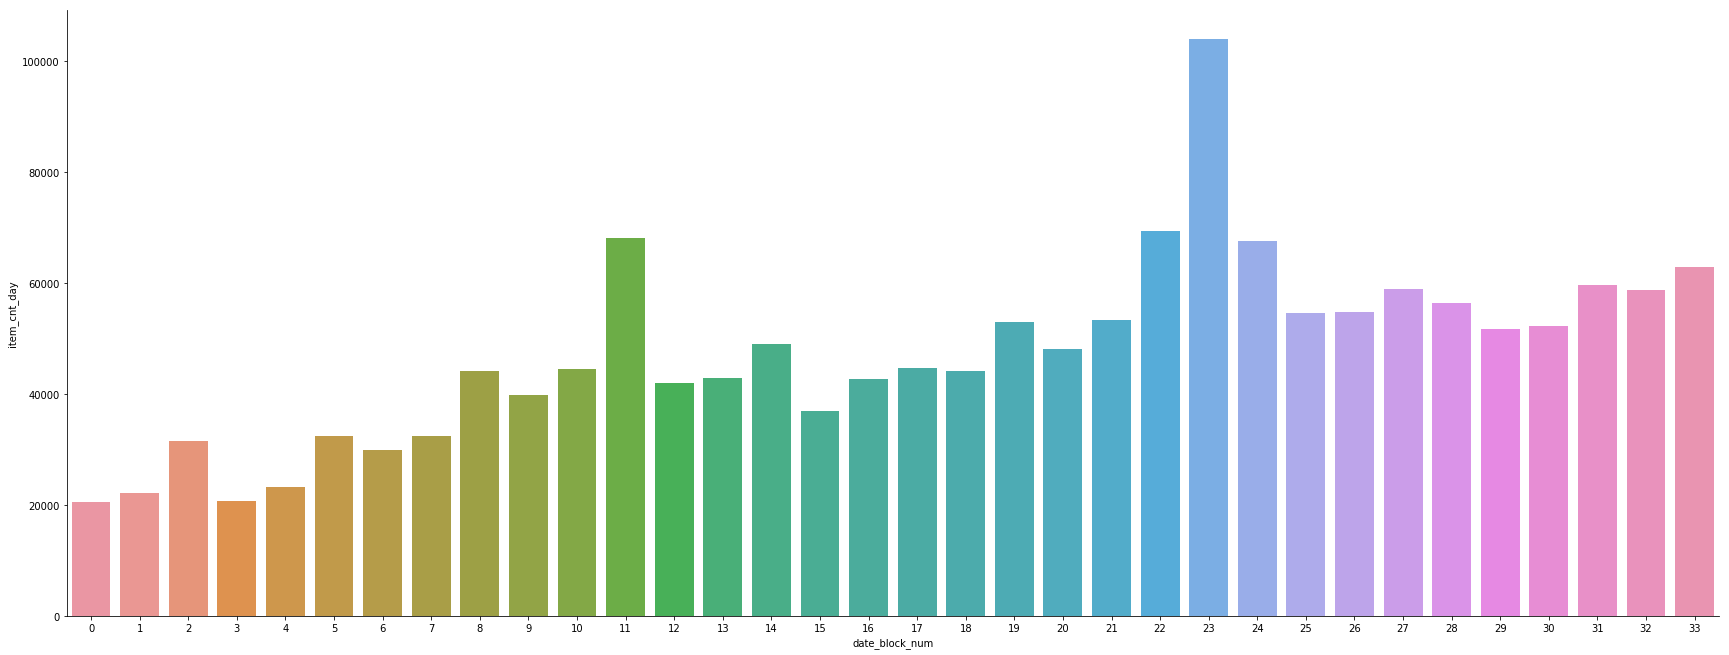

In [61]:
g_i = sns.catplot(x="date_block_num", y="item_cnt_day", kind="bar", data=train_i)
g_i.fig.set_size_inches(30,10)

In [71]:
test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


From the competition, it wants the final result to be item id and the item count per month. The prediction primarily depends on item_price item_id and item_cnt_day. Firstly, we need to clean the data.

In [62]:
train = train.drop(columns=['date', 'item_price'])


In [63]:
train = pd.merge(train,test, on=['shop_id', 'item_id'])

In [64]:
train = train.drop(columns=['shop_id','item_id'])

In [65]:
train = train.sort_values(['ID', 'date_block_num'])

In [66]:
train.head()

,date_block_num,item_cnt_day,ID
896436,20,1.0,0
896437,22,1.0,0
896438,23,1.0,0
896439,23,1.0,0
896440,24,1.0,0


In [67]:
train.max()

date_block_num        33.0
item_cnt_day        2169.0
ID                214199.0
dtype: float64

In [68]:
train.describe(include = 'all')

,date_block_num,item_cnt_day,ID
count,1.224439e+06,1.224439e+06,1.224439e+06
mean,1.935472e+01,1.321234e+00,9.517727e+04
std,9.110722e+00,3.312997e+00,5.651974e+04
min,0.000000e+00,-1.600000e+01,0.000000e+00
25%,1.200000e+01,1.000000e+00,4.784100e+04
50%,2.100000e+01,1.000000e+00,8.716000e+04
75%,2.700000e+01,1.000000e+00,1.400990e+05
max,3.300000e+01,2.169000e+03,2.141990e+05


In [69]:
train_i = train[['date_block_num', 'item_cnt_day']]
train_i = train_i.groupby(['date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})

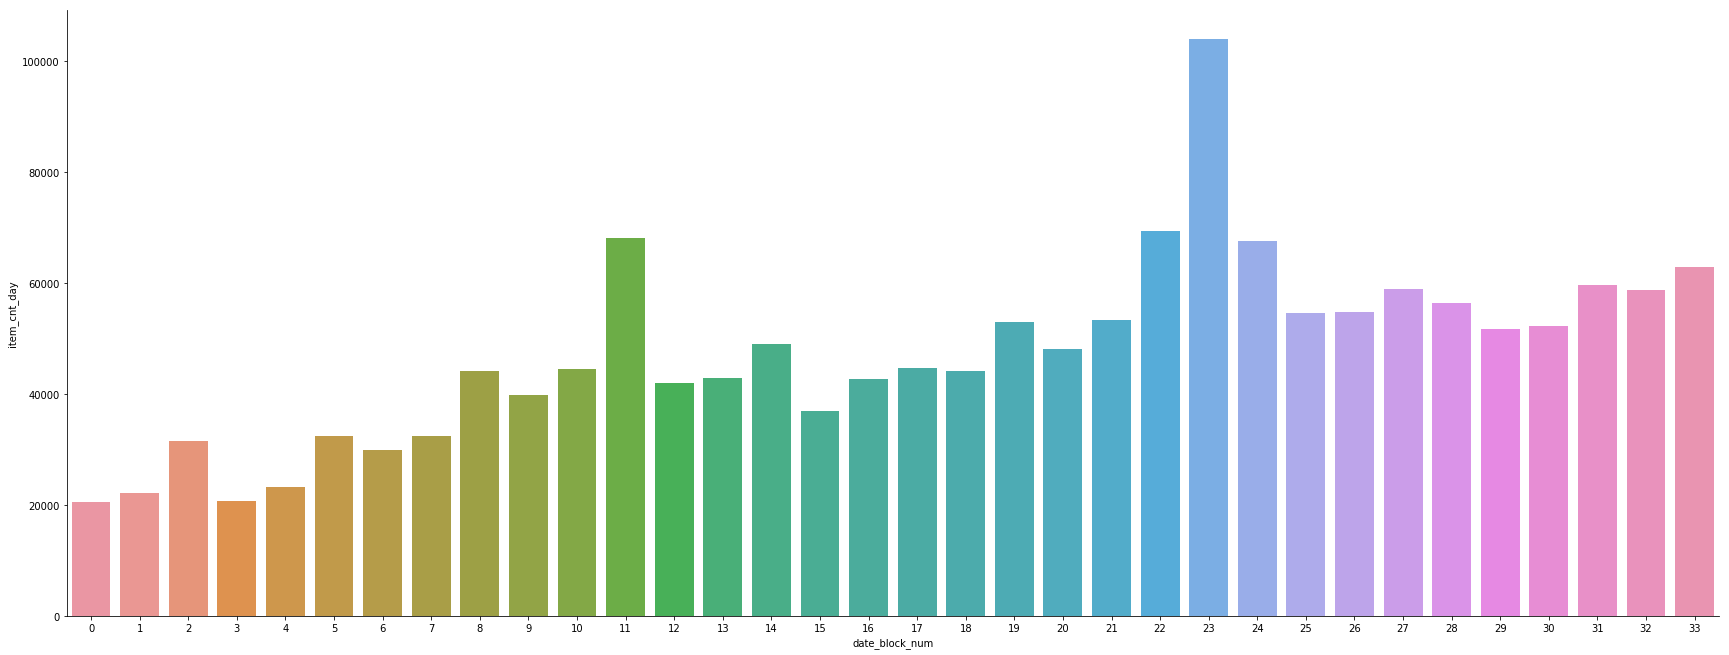

In [70]:
i_g = sns.catplot(x="date_block_num", y="item_cnt_day", kind="bar", data=train_i)
i_g.fig.set_size_inches(30,10)

In [9]:
train_by_month = train.groupby(['ID', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})

In [10]:
train_by_month.head()

,ID,date_block_num,item_cnt_day
0,0,20,1.0
1,0,22,1.0
2,0,23,2.0
3,0,24,2.0
4,0,28,1.0


In [11]:
train_by_month_short = train_by_month.loc[train_by_month['ID']<=214199]
train_by_month_short.head()

,ID,date_block_num,item_cnt_day
0,0,20,1.0
1,0,22,1.0
2,0,23,2.0
3,0,24,2.0
4,0,28,1.0


In [12]:
print(len(train_by_month_short))

600159


In [13]:
uniq_ID = train_by_month_short.ID.unique()
uniq_ID = np.array(["%d" % w for w in uniq_ID.reshape(uniq_ID.size)])
dic = {elem : pd.DataFrame for elem in uniq_ID}
for key in dic.keys():
    dic[key] = train_by_month_short[:][train_by_month_short.ID == int(key)]

In [14]:
for i in dic.keys():
    dic[i] = dic[i].sort_values('date_block_num')
    for j in range(34):
        if j not in dic[i].date_block_num.unique():
            dic[i] = dic[i].append({'ID': i, 'date_block_num': j}, ignore_index=True)
        

Check if the dataset is clean:

In [15]:
train.isna().sum()

date_block_num    0
item_cnt_day      0
ID                0
dtype: int64

In [16]:
train.dtypes

date_block_num      int64
item_cnt_day      float64
ID                  int64
dtype: object

Then group the data to get what we need to predict:

In [17]:
missing_list = []
for i in range(0,214200):
    if str(i) not in dic.keys():
        missing_list.append(i)
#missing_list

In [18]:
len(missing_list)

102796

In [19]:
not_in_market_list = []
for i in list(dic.keys()):
    if dic[i]['item_cnt_day'].loc[28:33].isna().sum() == 6:
        not_in_market_list.append(int(i))
        del dic[i]
        assert i not in dic.keys()
#not_in_market_list

In [20]:
len(not_in_market_list)

110535

In [21]:
len(dic)

869

In [22]:
new_to_market_dict = dict()
for i in list(dic.keys()):
    if dic[i]['item_cnt_day'].loc[0:27].isna().sum() == 28 and dic[i]['item_cnt_day'].loc[28,33].isna().sum() != 6:
        new_to_market_dict[int(i)] = dic[i]['item_cnt_day'].loc[28,33].mean()
        del dic[i]
        assert i not in dic.keys()
#new_to_market_dict

In [23]:
len(new_to_market_dict)

0

In [24]:
dic.keys()

dict_keys(['42', '43', '415', '460', '921', '973', '1291', '5143', '5185', '5374', '5496', '5515', '5560', '6159', '6189', '6305', '6391', '9020', '9844', '10222', '10227', '10241', '10242', '10243', '10408', '10474', '10495', '10596', '10615', '10620', '10660', '10761', '11121', '11259', '11289', '11337', '11405', '11447', '11467', '12823', '14120', '14944', '15342', '15343', '15508', '15760', '16505', '17923', '20442', '20484', '20485', '20486', '20815', '20830', '20860', '21321', '21459', '21667', '25522', '25527', '25542', '25543', '25584', '25585', '25586', '25708', '25718', '25774', '25896', '25915', '25960', '26049', '26052', '26421', '26473', '26485', '26589', '26637', '26705', '26767', '27528', '28123', '30244', '30643', '31015', '31060', '31521', '31689', '36195', '36298', '36300', '36303', '36621', '36951', '37296', '37319', '37325', '37341', '37350', '38839', '40822', '40827', '40841', '40842', '40843', '40884', '40885', '40886', '40897', '40914', '41008', '41018', '41031',

In [25]:
for i in list(dic.keys()):
    dic[i]['item_cnt_day'] = dic[i]['item_cnt_day'].interpolate()

In [26]:
from statsmodels.tsa.arima_model import ARIMA

In [27]:
time_series_dict = dict()
for i in list(dic.keys()):
    ts = dic[i]['item_cnt_day']
    model = ARIMA(ts, order=(1, 1, 0))
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(ts), len(ts),  typ='levels')
    time_series_dict[int(i)] = yhat
time_series_dict

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provide

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provide

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provide

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provide

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provide

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provide

{42: 34    4.137739
 dtype: float64, 43: 34    2.986878
 dtype: float64, 415: 34    3.955551
 dtype: float64, 460: 34    43.604568
 dtype: float64, 921: 34    0.988381
 dtype: float64, 973: 34    0.959718
 dtype: float64, 1291: 34    0.960173
 dtype: float64, 5143: 34    3.800517
 dtype: float64, 5185: 34    1.975709
 dtype: float64, 5374: 34    25.331227
 dtype: float64, 5496: 34    8.149477
 dtype: float64, 5515: 34    3.737555
 dtype: float64, 5560: 34    101.325274
 dtype: float64, 6159: 34    2.659736
 dtype: float64, 6189: 34    2.903393
 dtype: float64, 6305: 34    0.839879
 dtype: float64, 6391: 34    0.812074
 dtype: float64, 9020: 34    0.778658
 dtype: float64, 9844: 34    0.387383
 dtype: float64, 10222: 33    5.84359
 dtype: float64, 10227: 34    0.814296
 dtype: float64, 10241: 34    7.227413
 dtype: float64, 10242: 34    7.156678
 dtype: float64, 10243: 33    14.889031
 dtype: float64, 10408: 34    2.996795
 dtype: float64, 10474: 33    18.280133
 dtype: float64, 10495: 

In [28]:
len(time_series_dict)

869

In [29]:
time_series_dict[43]

34    2.986878
dtype: float64

In [30]:
869+102796+110535

214200

In [31]:
time_series_dict.keys()

dict_keys([42, 43, 415, 460, 921, 973, 1291, 5143, 5185, 5374, 5496, 5515, 5560, 6159, 6189, 6305, 6391, 9020, 9844, 10222, 10227, 10241, 10242, 10243, 10408, 10474, 10495, 10596, 10615, 10620, 10660, 10761, 11121, 11259, 11289, 11337, 11405, 11447, 11467, 12823, 14120, 14944, 15342, 15343, 15508, 15760, 16505, 17923, 20442, 20484, 20485, 20486, 20815, 20830, 20860, 21321, 21459, 21667, 25522, 25527, 25542, 25543, 25584, 25585, 25586, 25708, 25718, 25774, 25896, 25915, 25960, 26049, 26052, 26421, 26473, 26485, 26589, 26637, 26705, 26767, 27528, 28123, 30244, 30643, 31015, 31060, 31521, 31689, 36195, 36298, 36300, 36303, 36621, 36951, 37296, 37319, 37325, 37341, 37350, 38839, 40822, 40827, 40841, 40842, 40843, 40884, 40885, 40886, 40897, 40914, 41008, 41018, 41031, 41095, 41097, 41133, 41196, 41205, 41215, 41220, 41230, 41260, 41326, 41332, 41352, 41361, 41400, 41440, 41471, 41477, 41561, 41655, 41657, 41675, 41685, 41721, 41785, 41846, 41859, 41889, 41937, 42005, 42036, 42047, 42064, 4

In [32]:
import statsmodels.api as sm

In [33]:
vis_42 = sm.tsa.seasonal_decompose(dic['42']['item_cnt_day'],freq=12,model="additive")

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


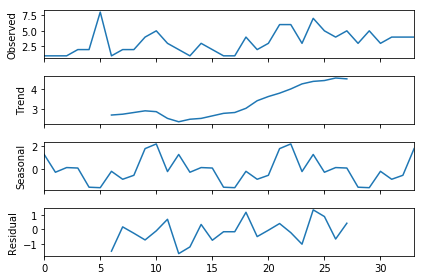

In [34]:
plot_42 = vis_42.plot()
plot_42.show()

In [35]:
vis_42_mult = sm.tsa.seasonal_decompose(dic['42']['item_cnt_day'],freq=12,model="multiplicative")

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


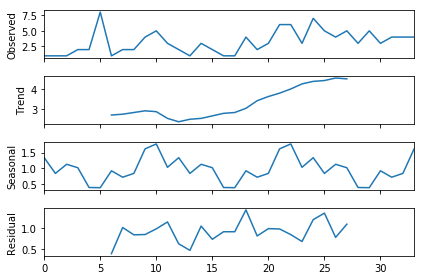

In [36]:
plot_42_mult = vis_42_mult.plot()
plot_42_mult.show()

In [37]:
vis_43 = sm.tsa.seasonal_decompose(dic['43']['item_cnt_day'],freq=12,model="additive")

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


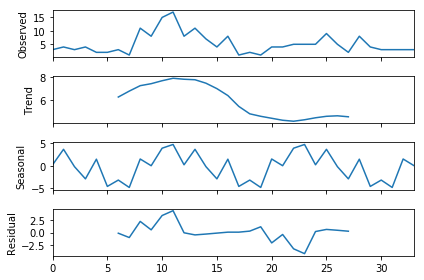

In [38]:
plot_43 = vis_43.plot()
plot_43.show()

In [39]:
#test = test.drop(['item_cnt_month'],axis=1)

In [40]:
test['item_cnt_month'] = 0

In [41]:
test = test.astype({'item_cnt_month': 'float'})

In [42]:
test.dtypes

ID                  int64
shop_id             int64
item_id             int64
item_cnt_month    float64
dtype: object

In [43]:
for i in time_series_dict.keys():
    test['item_cnt_month'][i] = float(time_series_dict[i])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
test['item_cnt_month'].notna().sum()

214200

In [45]:
test.loc[43]

ID                  43.000000
shop_id              5.000000
item_id           5822.000000
item_cnt_month       2.986878
Name: 43, dtype: float64

In [46]:
test['item_cnt_month'].astype('float32')

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
11        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        0.0
24        0.0
25        0.0
26        0.0
27        0.0
28        0.0
29        0.0
         ... 
214170    0.0
214171    0.0
214172    0.0
214173    0.0
214174    0.0
214175    0.0
214176    0.0
214177    0.0
214178    0.0
214179    0.0
214180    0.0
214181    0.0
214182    0.0
214183    0.0
214184    0.0
214185    0.0
214186    0.0
214187    0.0
214188    0.0
214189    0.0
214190    0.0
214191    0.0
214192    0.0
214193    0.0
214194    0.0
214195    0.0
214196    0.0
214197    0.0
214198    0.0
214199    0.0
Name: item_cnt_month, Length: 214200, dtype: float32

In [47]:
test = test.drop(['shop_id','item_id'],axis=1)

In [48]:
test[test['item_cnt_month'] != 0]

,ID,item_cnt_month
42,42,4.137739
43,43,2.986878
415,415,3.955551
460,460,43.604568
921,921,0.988381
973,973,0.959718
1291,1291,0.960173
5143,5143,3.800517
5185,5185,1.975709
5374,5374,25.331227


In [430]:
test.to_csv(r'my_prediction.csv',index=False)